# Future Network Constrained Linear Optimal Power Flow

PyPSA-GB can model the GB power system  by solving a network constrained Linear Optimal Power Flow (LOPF) problem. This notebook shows the example application of a future 3 day period.

In [1]:
import os
from dotenv import find_dotenv, load_dotenv

load_dotenv(find_dotenv())
src_path = os.environ.get('PROJECT_SRC')
os.chdir(src_path)

In [2]:
import pypsa
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})
plt.style.use('ggplot')
import pandas as pd
import cartopy.crs as ccrs

import data_reader_writer

## Setting up simulation

Set the required inputs for the LOPF: the start, end and year of simulation, and the timestep.

In [3]:
# write csv files for import
start = '2048-06-04 00:00:00'
end = '2048-06-06 23:30:00'
# year of simulation
year = int(start[0:4])
# time step as fraction of hour
time_step = 1.

Choose from one of the National Grid Future Energy Scenarios.

In [4]:
scenario = 'Leading The Way'
# scenario = 'Consumer Transformation'
# scenario = 'System Transformation'
# scenario = 'Steady Progression'

Choose a baseline year (from 2010-2020). The baseline year determines which historical load profile and weather dataset is used for the future year modelled. The National Grid FES modellers used 2012 as their baseline year.

In [5]:
year_baseline = 2020

data_reader_writer is a script written to read in data from the various sources and write csv files in the format required for populating a PyPSA network object

In [6]:
data_reader_writer.data_writer(start, end, time_step, year, demand_dataset='eload', year_baseline=year_baseline,
                               scenario=scenario, merge_generators=True)

c:\Users\alyden\Anaconda3\envs\PyPSA-GB\lib\site-packages\pandas\core\arrays\datetimes.py:741: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  warnings.warn(
c:\Users\alyden\Anaconda3\envs\PyPSA-GB\lib\site-packages\pandas\core\indexing.py:1667: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = value
C:\Users\alyden\OneDrive - University of Edinburgh\Python\PyPSA-GB v0.0.1\PyPSA-GB\interconnectors.py:201: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  df_FES = df_FES[~df_FES.Variable.str.contains('(TWh)')]


In [7]:
network = pypsa.Network()

network.import_from_csv_folder('LOPF_data')

Importing PyPSA from older version of PyPSA than current version.
Please read the release notes at https://pypsa.readthedocs.io/en/latest/release_notes.html
carefully to prepare your network for import.
Currently used PyPSA version [0, 20, 1], imported network file PyPSA version None.

INFO:pypsa.components:Applying weightings to all columns of `snapshot_weightings`
       'Tidal lagoon Penwortham', 'Tidal lagoon S.W.Penisula',
       'Tidal stream Deeside', 'Tidal stream Harker', 'Tidal stream Lovedean',
       'Tidal stream Melksham', 'Tidal stream Penwortham',
       'Tidal stream S.W.Penisula', 'Wave power Beauly', 'Wave power Melksham',
       'Wave power Neilston'],
      dtype='object', name='Generator') for attribute p_max_pu of Generator are not in main components dataframe generators
INFO:pypsa.io:Imported network LOPF_data has buses, generators, lines, links, loads, storage_units


Lines need to be scaled up to accomadate for future generation, and specific analysis will be done on this in a later notebook.
Note: interconnects are links in future, so don't need to be selective here (as was required in historical simulation).

In [8]:
contingency_factor = 4
network.lines.s_max_pu *= contingency_factor

## Running the optimisation

In [9]:
network.lopf(network.snapshots, solver_name="gurobi", pyomo=False)

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.92s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Set parameter Username
Academic license - for non-commercial use only - expires 2023-10-19
Read LP format model from file C:\Users\alyden\AppData\Local\Temp\pypsa-problem-3p3f9at8.lp
Reading time = 0.72 seconds
obj: 309438 rows, 88057 columns, 543257 nonzeros
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 309438 rows, 88057 columns and 543257 nonzeros
Model fingerprint: 0x6197f4c4
Coefficient statistics:
  Matrix range     [6e-05, 1e+00]
  Objective range  [1e+00, 1e+09]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-02, 1e+09]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 299006 rows and 55997 columns
Presolve time: 0.21s
Presolved: 10432 rows, 32628 columns, 63625 nonzeros

Ordering time: 0.09s

Barrier statistics:
 AA' NZ     : 2.825e+04
 Factor NZ  : 4.826e+05 (roughly 20 MB of memory)
 Factor Ops : 6.013e+07 (less th

INFO:pypsa.linopf:Optimization successful. Objective value: 2.75e+12


('ok', 'optimal')

## Power output by generation type

Group the generators by the carrier, and print their summed power outputs over the simulation period.

In [10]:
p_by_carrier = network.generators_t.p.groupby(
    network.generators.carrier, axis=1).sum()

storage_by_carrier = network.storage_units_t.p.groupby(
    network.storage_units.carrier, axis=1).sum()

# to show on graph set the negative storage values to zero
storage_by_carrier[storage_by_carrier < 0] = 0

p_by_carrier = pd.concat([p_by_carrier, storage_by_carrier], axis=1)

print(network.links_t.p0)
imp = network.links_t.p0.copy()
imp[imp < 0] = 0
imp['Interconnectors Import'] = imp.sum(axis=1)
interconnector_import = imp[['Interconnectors Import']]
print(interconnector_import)

p_by_carrier = pd.concat([p_by_carrier, interconnector_import], axis=1)

exp = network.links_t.p0.copy()
exp[exp > 0] = 0
exp['Interconnectors Export'] = exp.sum(axis=1)
interconnector_export = exp[['Interconnectors Export']]
print(interconnector_export)

# group biomass stuff
p_by_carrier['Biomass'] = (
    p_by_carrier['Biomass (dedicated)'] + p_by_carrier['Biomass (co-firing)'] +
    p_by_carrier['Landfill Gas'] + p_by_carrier['Anaerobic Digestion'] +
    p_by_carrier['Sewage Sludge Digestion'])

# rename the hydro bit
p_by_carrier = p_by_carrier.rename(
    columns={'Large Hydro': 'Hydro'})
p_by_carrier = p_by_carrier.rename(
    columns={'Interconnector': 'Interconnectors Import'})

p_by_carrier

Link                 BritNed  EastWest  Moyle  Nemo     IFA    IFA2     NSL  \
snapshot                                                                      
2048-06-04 00:00:00      0.0       0.0    0.0   0.0   700.0  1750.0  2450.0   
2048-06-04 01:00:00      0.0       0.0    0.0   0.0   700.0  1750.0  2450.0   
2048-06-04 02:00:00      0.0       0.0    0.0   0.0 -3500.0  1750.0  2450.0   
2048-06-04 03:00:00      0.0       0.0    0.0   0.0   700.0  1750.0  2450.0   
2048-06-04 04:00:00      0.0       0.0    0.0   0.0   700.0  1750.0  2450.0   
...                      ...       ...    ...   ...     ...     ...     ...   
2048-06-06 19:00:00      0.0       0.0    0.0   0.0   700.0  1750.0  2450.0   
2048-06-06 20:00:00      0.0       0.0    0.0   0.0   700.0  1750.0  2450.0   
2048-06-06 21:00:00      0.0       0.0    0.0   0.0   700.0  1750.0  2450.0   
2048-06-06 22:00:00      0.0       0.0    0.0   0.0   700.0  1750.0  2450.0   
2048-06-06 23:00:00      0.0       0.0    0.0   0.0 

,Anaerobic Digestion,Biomass (co-firing),Biomass (dedicated),CCS Biomass,CCS Gas,EfW Incineration,Hydrogen,Landfill Gas,Hydro,Natural Gas,...,Unmet Load,Wave power,Wind Offshore,Wind Onshore,Battery,Compressed Air,Liquid Air,Pumped Storage Hydroelectric,Interconnectors Import,Biomass
snapshot,,,,,,,,,,,,,,,,,,,,,
2048-06-04 00:00:00,294.9,0.0,0.0,0.0,0.0,835.67304,0.0,699.4,32.470097,0.0,...,0.0,16.85600,27965.087010,7290.377377,7470.837226,20.600098,125.805821,4799.900000,6650.0,1044.5
2048-06-04 01:00:00,269.5,0.0,0.0,0.0,0.0,734.71716,0.0,579.1,0.000000,0.0,...,0.0,16.85600,28334.107204,6581.907963,949.995035,0.000000,0.000000,3442.078218,6650.0,898.8
2048-06-04 02:00:00,286.7,0.0,0.0,0.0,0.0,835.67304,0.0,695.7,20.989493,0.0,...,0.0,16.85600,31276.718943,6482.437157,0.000000,101.037100,66.449444,509.183168,7700.0,1032.6
2048-06-04 03:00:00,280.7,0.0,0.0,0.0,0.0,758.44584,0.0,623.7,10.411351,0.0,...,0.0,16.85600,33739.884037,5994.465740,0.000000,43.073058,0.000000,242.256312,6650.0,954.6
2048-06-04 04:00:00,294.9,0.0,0.0,0.0,0.0,835.67304,0.0,699.4,23.351199,0.0,...,0.0,16.85600,30868.111272,5962.156578,3038.493910,59.836904,4.625646,746.801980,6650.0,1044.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2048-06-06 19:00:00,305.9,0.0,0.0,0.0,0.0,840.84228,0.0,706.7,82.155311,0.0,...,0.0,46.15233,29891.208373,10551.623207,11163.885192,2211.100214,1351.743701,611.019802,6650.0,1062.8
2048-06-06 20:00:00,314.1,0.0,0.0,0.0,0.0,840.84228,0.0,732.8,130.064125,0.0,...,0.0,46.15233,40696.123793,9198.161669,7409.828182,1850.152054,807.214745,0.000000,6650.0,1097.1
2048-06-06 21:00:00,314.1,0.0,0.0,0.0,0.0,840.84228,0.0,732.8,122.351019,0.0,...,0.0,26.08767,41967.423911,7490.236737,5398.014995,2102.064381,979.777337,2932.895050,6650.0,1097.1


Graph the power output of the different generation types...

c:\Users\alyden\Anaconda3\envs\PyPSA-GB\lib\site-packages\pandas\plotting\_matplotlib\core.py:1391: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(None, 0)


Text(0.5, 0, '')

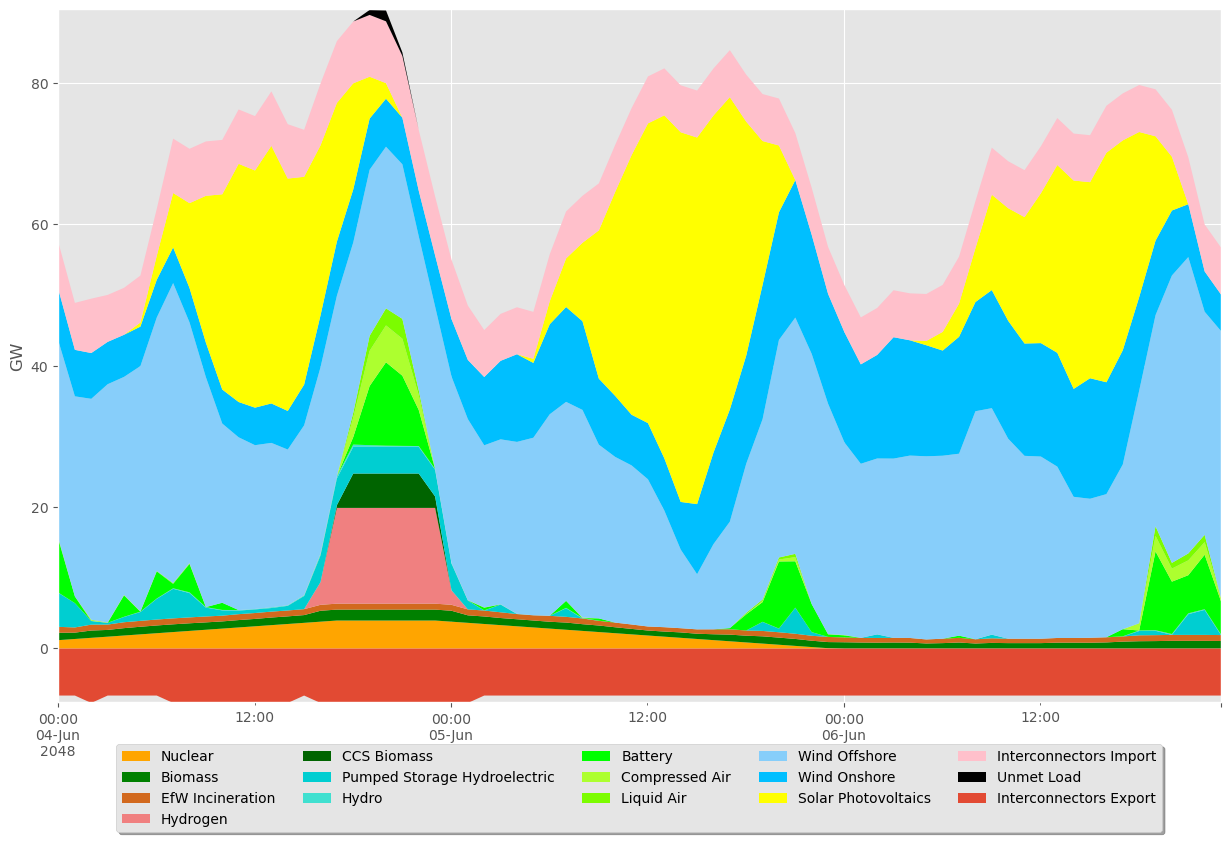

In [11]:
cols = ["Nuclear", 'Biomass',
        'EfW Incineration', "Oil", "Natural Gas",
        'Hydrogen', 'CCS Gas', 'CCS Biomass',
        "Pumped Storage Hydroelectric", 'Hydro',
        'Battery', 'Compressed Air', 'Liquid Air',
        "Wind Offshore", 'Wind Onshore', 'Solar Photovoltaics',
        'Interconnectors Import', 'Unmet Load'
        ]

p_by_carrier = p_by_carrier[cols]

p_by_carrier.drop(
    (p_by_carrier.max()[p_by_carrier.max() < 50.0]).index,
    axis=1, inplace=True)


colors = {"Coal": "grey",
          "Diesel/Gas oil": "black",
          "Diesel/gas Diesel/Gas oil": "black",
          'Oil': 'black',
          'Unmet Load': 'black',
          'Anaerobic Digestion': 'green',
          'EfW Incineration': 'chocolate',
          'Sewage Sludge Digestion': 'green',
          'Landfill Gas': 'green',
          'Biomass (dedicated)': 'green',
          'Biomass (co-firing)': 'green',
          'Biomass': 'green',
          'CCS Biomass': 'darkgreen',
          'Interconnectors Import': 'pink',
          "Sour gas": "lightcoral",
          "Natural Gas": "lightcoral",
          'CCS Gas': "lightcoral",
          'Hydrogen': "lightcoral",
          "Nuclear": "orange",
          'Shoreline Wave': 'aqua',
          'Tidal Barrage and Tidal Stream': 'aqua',
          'Hydro': "turquoise",
          "Large Hydro": "turquoise",
          "Small Hydro": "turquoise",
          "Pumped Storage Hydroelectric": "darkturquoise",
          'Battery': 'lime',
          'Compressed Air': 'greenyellow',
          'Liquid Air': 'lawngreen',
          "Wind Offshore": "lightskyblue",
          'Wind Onshore': 'deepskyblue',
          'Solar Photovoltaics': 'yellow'}

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15,10)
(p_by_carrier / 1e3).plot(
    kind="area", ax=ax, linewidth=0,
    color=[colors[col] for col in p_by_carrier.columns])

# stacked area plot of negative values, prepend column names with '_' such that they don't appear in the legend
(interconnector_export / 1e3).plot.area(ax=ax, stacked=True, linewidth=0.)
# rescale the y axis
ax.set_ylim([(interconnector_export / 1e3).sum(axis=1).min(), (p_by_carrier / 1e3).sum(axis=1).max()])

# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)

ax.set_ylabel("GW")

ax.set_xlabel("")

## Plotting storage

Graph the pumped hydro dispatch and state of charge...

Text(0.5, 0, '')

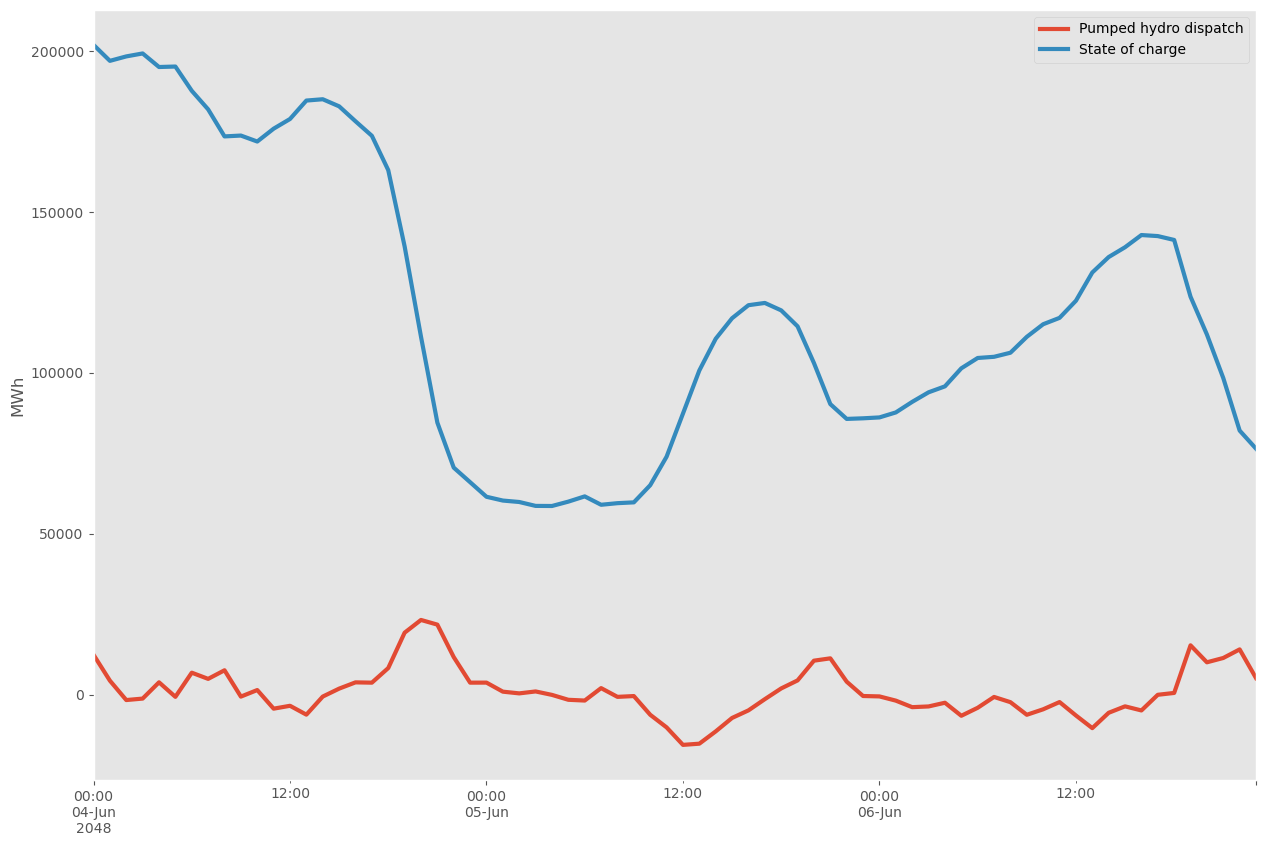

In [12]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15,10)

p_storage = network.storage_units_t.p.sum(axis=1)
state_of_charge = network.storage_units_t.state_of_charge.sum(axis=1)
p_storage.plot(label="Pumped hydro dispatch", ax=ax, linewidth=3)
state_of_charge.plot(label="State of charge", ax=ax, linewidth=3)

ax.legend()
ax.grid()
ax.set_ylabel("MWh")
ax.set_xlabel("")

## Plotting line loading

Look at the line loading stats and graph...

In [13]:
now = network.snapshots[60]

print("With the linear load flow, there is the following per unit loading:")
loading = network.lines_t.p0.loc[now] / network.lines.s_nom
loading.describe()

With the linear load flow, there is the following per unit loading:


count    99.000000
mean     -0.621391
std       0.860864
min      -3.470894
25%      -1.104903
50%      -0.478682
75%      -0.100539
max       1.212480
dtype: float64

(<matplotlib.collections.PatchCollection at 0x1ebc72cf4c0>,
 <matplotlib.collections.LineCollection at 0x1ebc6e30eb0>)

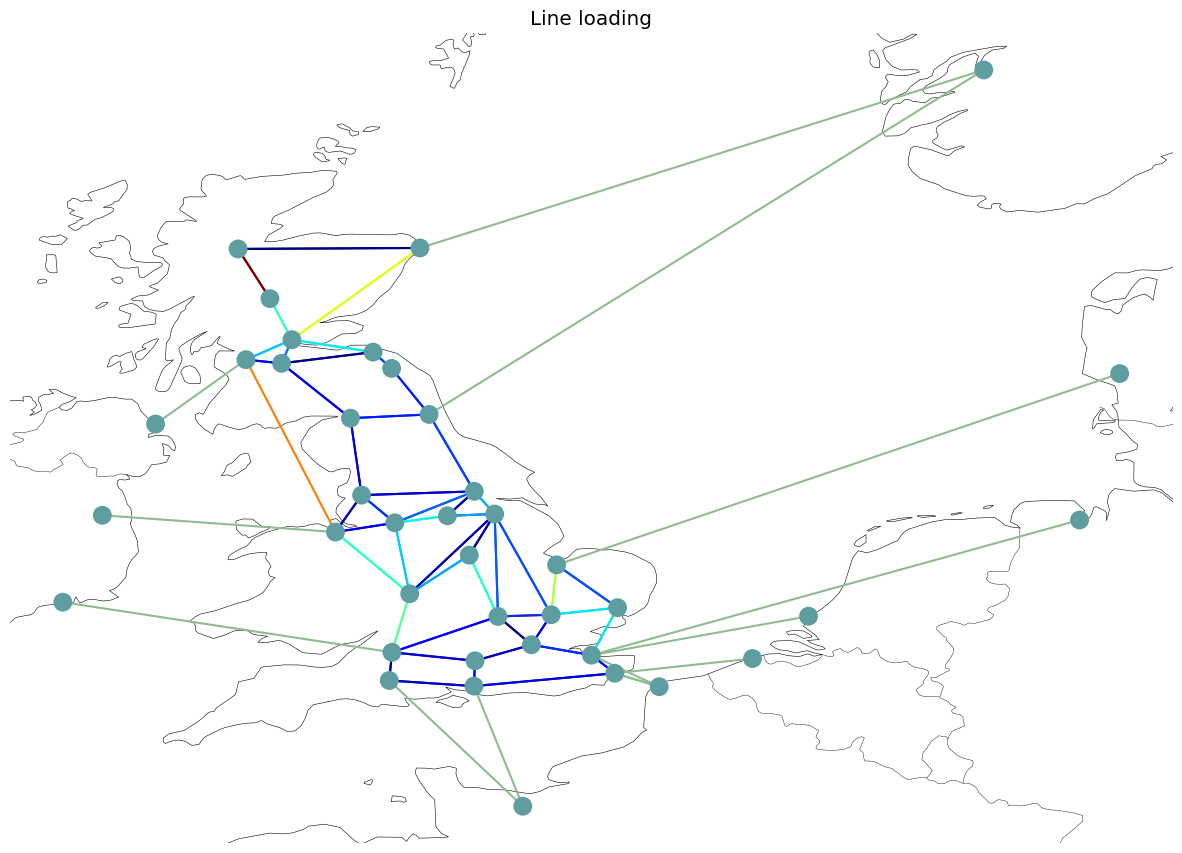

In [14]:
fig, ax = plt.subplots(1, 1, subplot_kw={"projection": ccrs.PlateCarree()})
fig.set_size_inches(15, 17)

network.plot(ax=ax, line_colors=abs(loading), line_cmap=plt.cm.jet, title="Line loading")

## Plotting locational marginal prices

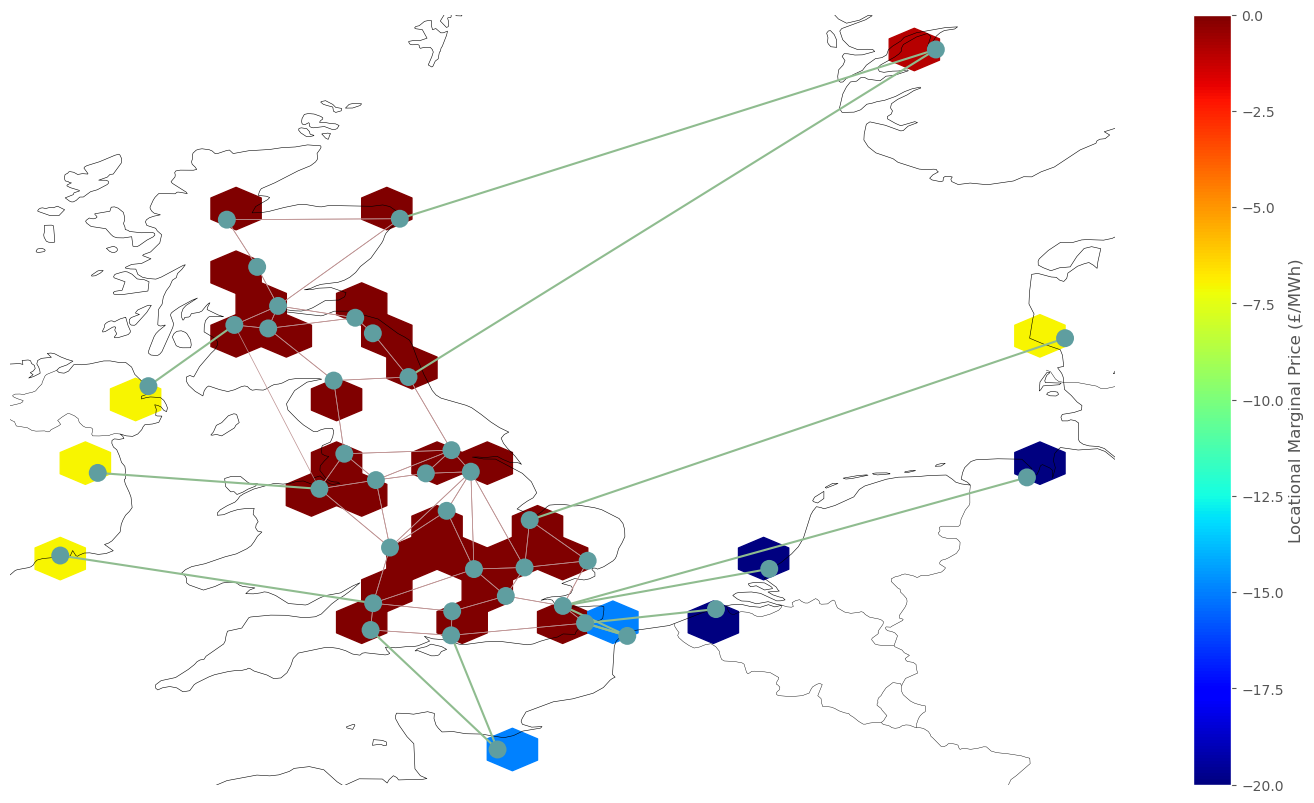

In [15]:
fig, ax = plt.subplots(1, 1, subplot_kw={"projection": ccrs.PlateCarree()})
fig.set_size_inches(20, 10)

network.plot(ax=ax, line_widths=pd.Series(0.5, network.lines.index))
plt.hexbin(network.buses.x, network.buses.y,
           gridsize=20,
           C=network.buses_t.marginal_price.loc[now],
           cmap=plt.cm.jet)

# for some reason the colorbar only works with graphs plt.plot
# and must be attached plt.colorbar

cb = plt.colorbar()
cb.set_label('Locational Marginal Price (£/MWh)')

In [16]:
network.buses_t.marginal_price

Bus,Beauly,Peterhead,Errochty,Denny/Bonnybridge,Neilston,Strathaven,Torness,Eccles,Harker,Stella West,...,Netherlands,Belgium,France1,France2,Ireland,N. Ireland,Denmark,Norway,Germany,Ireland2
snapshot,,,,,,,,,,,,,,,,,,,,,
2048-06-04 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-20.0,-20.0,-15.0,-15.0,-7.0,-7.0,-7.0,-1.0,-20.0,-7.0
2048-06-04 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-20.0,-20.0,-15.0,-15.0,-7.0,-7.0,-7.0,-1.0,-20.0,-7.0
2048-06-04 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-20.0,-20.0,-15.0,-15.0,-7.0,-7.0,-7.0,-1.0,-20.0,-7.0
2048-06-04 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-20.0,-20.0,-15.0,-15.0,-7.0,-7.0,-7.0,-1.0,-20.0,-7.0
2048-06-04 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-20.0,-20.0,-15.0,-15.0,-7.0,-7.0,-7.0,-1.0,-20.0,-7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2048-06-06 19:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-20.0,-20.0,-15.0,-15.0,-7.0,-7.0,-7.0,-1.0,-20.0,-7.0
2048-06-06 20:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-20.0,-20.0,-15.0,-15.0,-7.0,-7.0,-7.0,-1.0,-20.0,-7.0
2048-06-06 21:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-20.0,-20.0,-15.0,-15.0,-7.0,-7.0,-7.0,-1.0,-20.0,-7.0


## Plotting curtailment

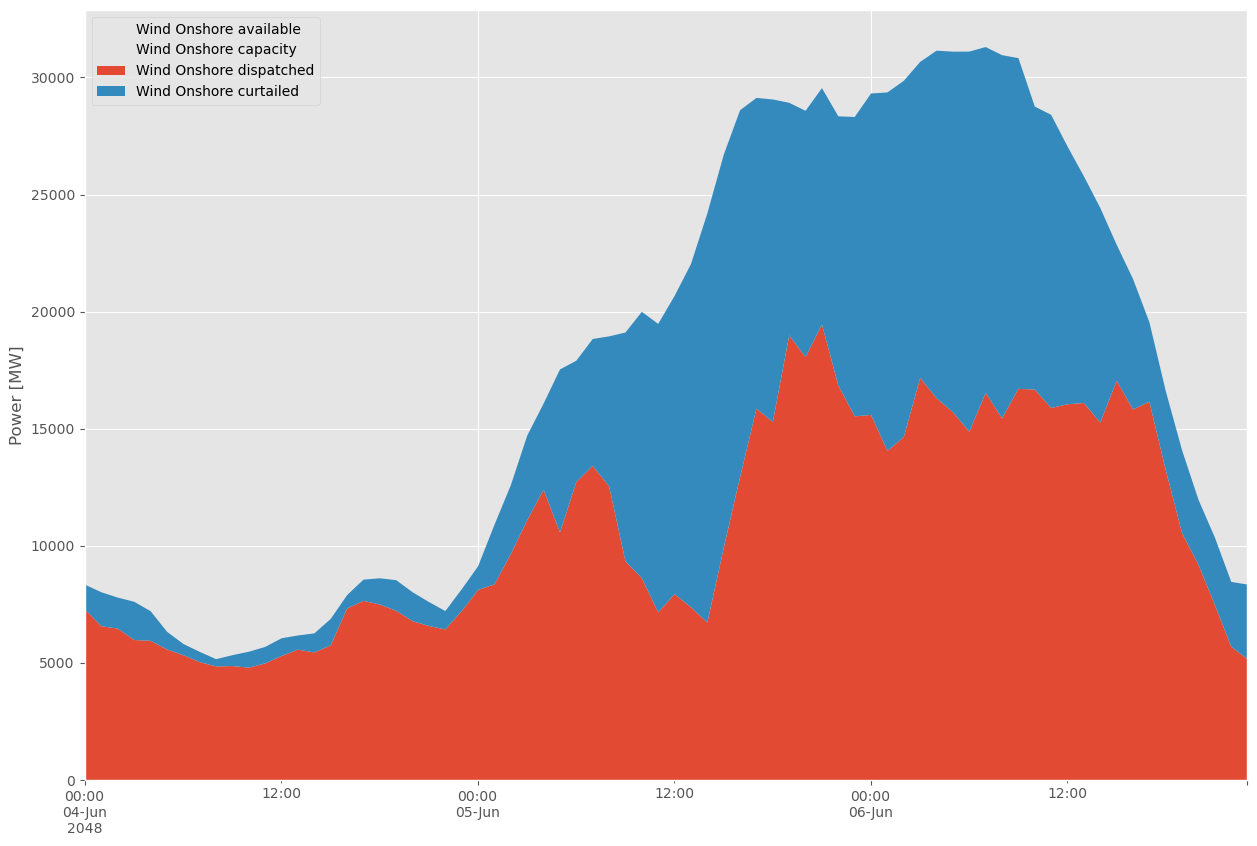

In [17]:
carrier = "Wind Onshore"

capacity = network.generators.groupby("carrier").sum().at[carrier, "p_nom"]
p_available = network.generators_t.p_max_pu.multiply(network.generators["p_nom"])
p_available_by_carrier = p_available.groupby(network.generators.carrier, axis=1).sum()
p_curtailed_by_carrier = p_available_by_carrier - p_by_carrier
p_df = pd.DataFrame({carrier + " available": p_available_by_carrier[carrier],
                     carrier + " dispatched": p_by_carrier[carrier],
                     carrier + " curtailed": p_curtailed_by_carrier[carrier]})

p_df[carrier + " capacity"] = capacity
p_df["Wind Onshore curtailed"][p_df["Wind Onshore curtailed"] < 0.] = 0.
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15,10)
p_df[[carrier + " dispatched", carrier + " curtailed"]].plot(kind="area", ax=ax, linewidth=0)
p_df[[carrier + " available", carrier + " capacity"]].plot(ax=ax, linewidth=0)

ax.set_xlabel("")
ax.set_ylabel("Power [MW]")
ax.legend()